<a href="https://colab.research.google.com/github/serafa11/business_financial_analysis/blob/main/Sales_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
sales = pd.read_csv("sales.csv")
sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [ ]:
# check for null values
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [ ]:
# in this case we don't focus on the items or store id's. therefore we drop them
sales = sales.drop(["store", "item"], axis=1)

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [ ]:
# right now date is in the wrong Dtype object, set it up as dateTime Dtype

sales["date"] = pd.to_datetime(sales["date"])

In [ ]:
# converting date to a Month period, and then sum the # of items in each month

sales["date"] = sales["date"].dt.to_period('M')
monthly_sales = sales.groupby("date").sum().reset_index()


In [ ]:
#convert the resultind date to timestamp datatype

monthly_sales["date"] = monthly_sales["date"].dt.to_timestamp()

In [ ]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


Vizualization

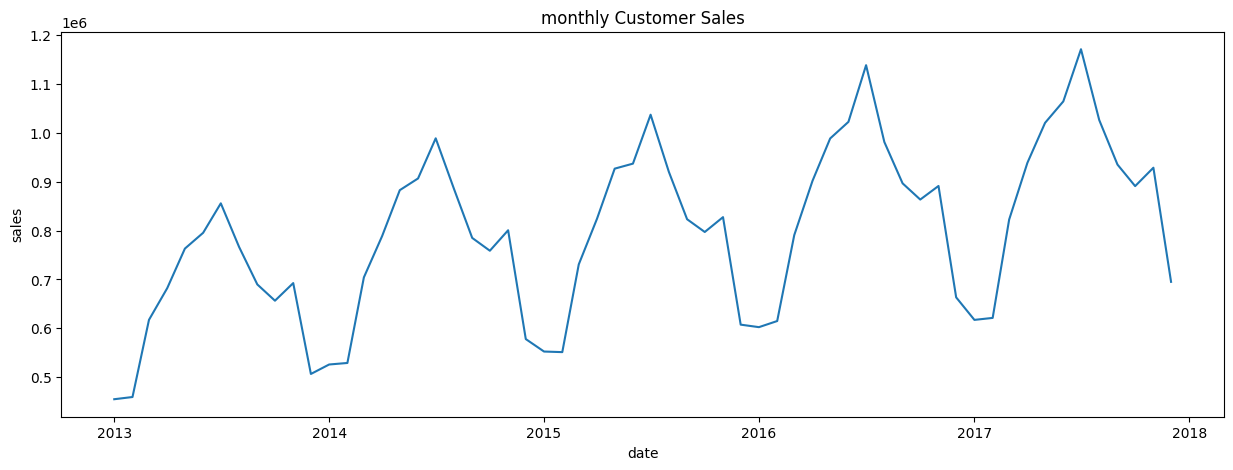

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(monthly_sales["date"], monthly_sales["sales"])
plt.xlabel("date")
plt.ylabel("sales")
plt.title("monthly Customer Sales")
plt.show()

Call the difference on the sales columns to make the sales data stationary

In [ ]:
monthly_sales["sales_dif"] = monthly_sales["sales"].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_dif
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


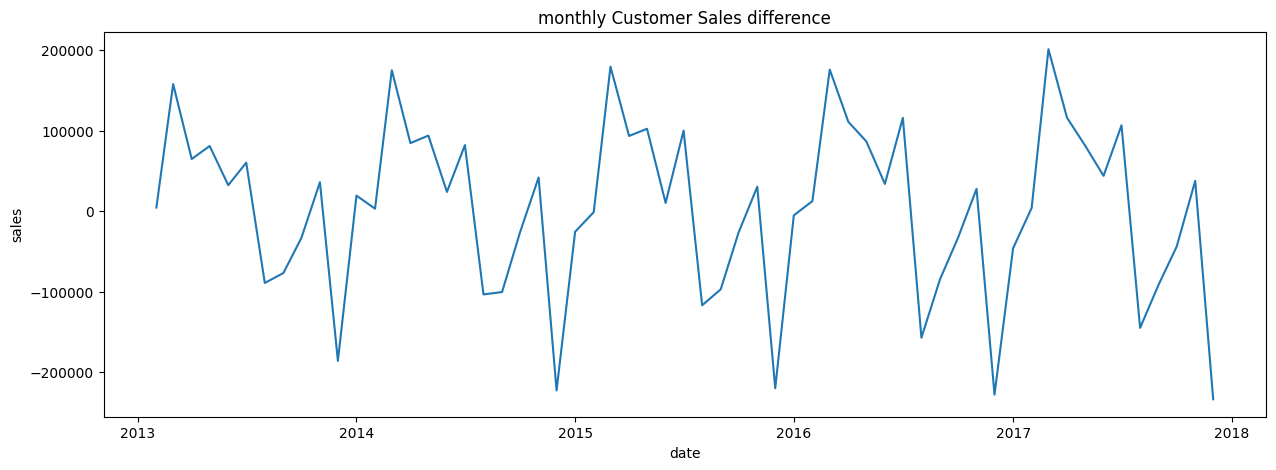

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales["date"], monthly_sales["sales_dif"])
plt.xlabel("date")
plt.ylabel("sales")
plt.title("monthly Customer Sales difference")
plt.show()

MODEL;
Dropping sales and date

In [ ]:
supervised_data = monthly_sales.drop(["date", "sales"], axis=1)

preparing the supervised data

In [ ]:
for i in range(1,13):
  col_name = 'month'+ str(i)
  supervised_data[col_name] = supervised_data["sales_dif"].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_dif,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


Split the data into train and test

In [ ]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train data shape is:", train_data.shape)
print("Test data shape is:", test_data.shape)


Train data shape is: (35, 13)
Test data shape is: (12, 13)


In [ ]:
scaler =MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data =scaler.transform(train_data)
test_data =scaler.transform(test_data)

In [ ]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape is:", x_train.shape)
print("y_train shape is:", y_train.shape)
print("x_test shape is:", x_test.shape)
print("y_test shape is:", y_test.shape)

x_train shape is: (35, 12)
y_train shape is: (35,)
x_test shape is: (12, 12)
y_test shape is: (12,)


Make prediction of dataframe to merge the predicted sale prices of all trained alg

In [ ]:
sales_dates = monthly_sales["date"][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [ ]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


Create the linear reg model, and predicted output

In [ ]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)

In [ ]:
import numpy as np

In [ ]:
lr_pred = lr_pred.reshape(-1,1)
#this is a set matrix - contains the input features of the test data and also the predicted output
lr_pred_test_set = np.concatenate([lr_pred, x_test,], axis=1)
lr_pred_test_set = scaler.inverse_transform(lr_pred_test_set)

In [ ]:
result_list = []
for index in range(0, len(lr_pred_test_set)):
  result_list.append(lr_pred_test_set[index][0] + act_sales[index])

lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index = True, right_index= True)

In [ ]:
# for evaluation we will use: the mean squared error mse, the mean absolute error mae and the R2
lr_mse = np.sqrt(mean_squared_error(predict_df["Linear Prediction"], monthly_sales["sales"][-12:]))
lr_mae = mean_absolute_error(predict_df["Linear Prediction"], monthly_sales["sales"][-12:])
lr_r2 = r2_score(predict_df["Linear Prediction"], monthly_sales["sales"][-12:])
print("Linera Regression MSE:", lr_mse)
print("Linera Regression MAE:", lr_mae)
print("Linera Regression R2:", lr_r2)

Linera Regression MSE: 16221.272385416869
Linera Regression MAE: 12433.184266490736
Linera Regression R2: 0.9906152516380969


Visualization of the prediction against the actual sales

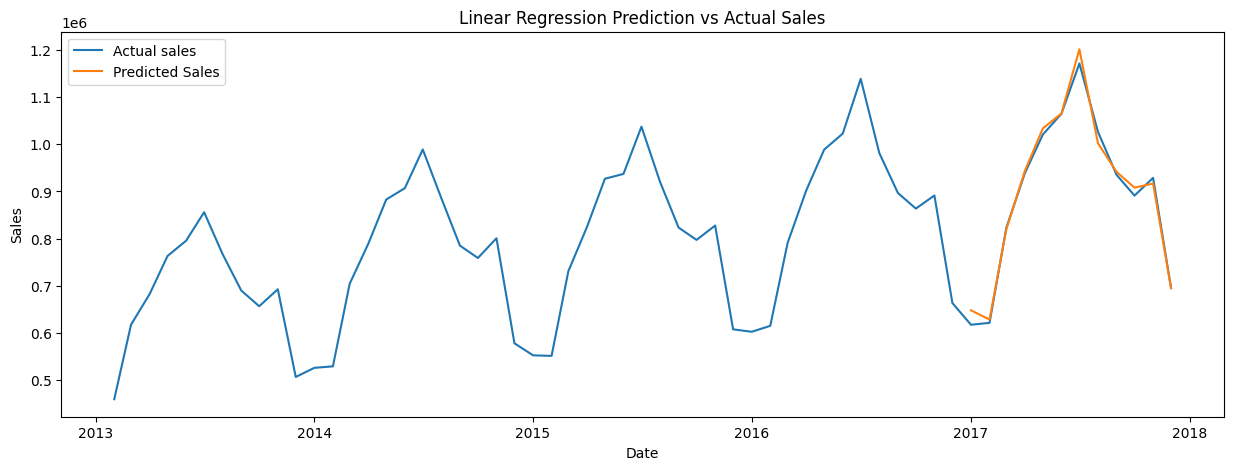

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
#The predicted sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title('Linear Regression Prediction vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend(['Actual sales', 'Predicted Sales'])
plt.show()